In [83]:
#pip install natsort
import pandas as pd
import numpy as np
import natsort # 파일 숫자 정렬용 라이브러리
import os
import librosa

## 0. MFCC 코드

In [84]:
#https://www.analyticsvidhya.com/blog/2022/03/implementing-audio-classification-project-using-deep-learning/
#https://stackoverflow.com/questions/52841335/how-can-i-pad-wav-file-to-specific-length
from librosa.util import fix_length
from librosa import load
from tqdm import tqdm

def features_extractor(file):
    #load the file (audio)
    file_name = file
    sf = 44100 # sampling frequency of wav file
    
    audio, sample_rate = librosa.load(file_name, sr=sf, mono=True) # mono=True converts stereo audio to mono
        
    #we extract mfcc'
    mfccs_features = librosa.feature.mfcc(y=audio, n_mfcc=20, sr=sf) ## --> n_mfcc : 20 ~ 50
    #print("mfccs_features",mfccs_features.shape)

    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) ## 평균으로 출력
    
    #print("mfccs_scaled_features", mfccs_scaled_features.shape)
    return mfccs_scaled_features

## 1. feature 데이터 가공하기

In [85]:
file_list = natsort.natsorted(os.listdir("music3_audio_wav"))

extracted_features=[]
extracted_len_features=[]
file_total_len = 1 # feature_input 길이 ex). 1초, 2초

start_sec = 5 # 파일 갯수 정하기 ex 1 ~ 24
end_sec = 472
count = 0

for filename in file_list[start_sec-1:end_sec]:
    file_name = os.path.join("music3_audio_wav", filename) ## 만약에 2초마다 붙이고 싶으면
    # print(file_name)
    data = features_extractor(file_name)
    extracted_len_features = np.concatenate((extracted_len_features, data))
    count+=1
    
    if (count == file_total_len):
        extracted_features.append(extracted_len_features)
        
        extracted_len_features=[]
        count = 0

    
extracted_features_df=pd.DataFrame(extracted_features)

for column_name in extracted_features_df:
    extracted_features_df.rename(columns={column_name:"f"+str(column_name+1)},inplace=True)


## 2. skeleton 데이터 가공하기

In [86]:
skeleton = pd.read_csv('music3_hand_result.csv')

extracted_skeleton=[] ### 궁금한게 초 길이 ## 다음 순차적으로 데이터 이어 붙이기 해야할 것같음

interval = 1
start_frame = (start_sec+interval) * 30 # 실제 csv : ( row = 2부터 시작 ) // 한 칸씩 떼기
end_frame = (end_sec+interval) * 30

frame_count = 30 # 1초 = 30 frame

skeleton_col = ['INDEX_FINGER_PIP_LX'] # 원하는 column 에 대해서만 ex. 6번 = INDEX_FINGER_PIP_LX

for frame_num in range(start_frame, end_frame + 1, frame_count): # start_frame ~ end_frame
    extracted_total_skeleton=[]
    for col in skeleton_col:
        extracted_skeleton_list = list(skeleton.loc[frame_num:(frame_num+frame_count)-1, col])
        extracted_total_skeleton = np.concatenate((extracted_total_skeleton, extracted_skeleton_list))
    extracted_skeleton.append(extracted_total_skeleton)

extracted_skeleton_df = pd.DataFrame(extracted_skeleton)

for column_name in extracted_skeleton_df:
    extracted_skeleton_df.rename(columns={column_name:"s"+str(column_name+1)},inplace=True)

In [87]:
total_data = pd.concat([extracted_features_df, extracted_skeleton_df],axis=1)
total_data

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30
0,-1131.370728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,624.980011,624.515686,625.626717,626.742325,627.196388,628.167343,629.288254,0.000000,0.000000,0.000000
1,-1131.370728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,741.540604,740.039139,738.791885,741.518402,965.318375,969.375534,968.527985,971.133652,974.208984,977.286148
2,-600.161072,83.292892,-0.855606,-6.247252,9.514754,1.260838,-3.974618,-1.122937,-2.315084,-0.782426,...,986.818085,990.895920,992.306366,992.766876,748.146439,751.155319,0.000000,0.000000,747.904053,748.794479
3,-314.307526,294.265228,-18.235453,-43.241116,23.966576,1.268239,-17.122757,-0.672371,-0.464282,-2.445030,...,1016.501160,762.037048,757.047043,1000.429916,997.305298,747.657471,0.000000,991.153412,993.239441,1000.373993
4,-286.899841,295.656647,-25.355766,-38.542938,30.198391,-1.347459,-17.192017,3.857743,2.328808,1.493181,...,982.200012,978.328552,974.822617,968.667984,966.926193,941.512299,964.371872,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,-499.660553,226.774216,24.239323,-34.519707,-4.645311,-6.661662,-24.467012,-17.183765,-8.609711,-11.367735,...,676.137314,553.682327,552.782555,552.999458,676.048203,675.833435,675.321121,675.325851,675.530701,675.846405
464,-519.125061,196.360794,20.975153,-37.906445,-8.972572,-2.429075,-21.040472,-20.170307,-9.023230,-9.146351,...,688.920212,689.198761,690.185700,689.881744,688.283386,688.633118,689.013825,689.306183,689.485626,689.206009
465,-664.719604,237.568832,34.023125,-27.980137,4.174069,5.959048,-15.679664,-12.246822,-1.270034,-7.274833,...,687.667694,687.689285,687.410126,688.717880,689.070664,689.700165,690.522080,690.021896,691.720810,691.699905
466,-642.387573,211.626724,58.024738,-17.231331,-9.627137,5.180705,-0.984878,-5.853268,-4.523614,-8.410495,...,689.105835,686.911392,686.934891,686.820145,686.609802,688.552475,689.970245,688.107758,687.123413,687.262878


In [23]:
total_data.to_csv("music3_combine.csv")

## 3. Train, Test 데이터 생성

In [88]:
import pandas as pd
total_data = pd.read_csv('music2_combine.csv')

In [89]:
total_data.drop('Unnamed: 0', inplace=True, axis=1)

In [90]:
f_list = []
s_list = []
for col in total_data.columns:
    if (col.find("f")!=-1):
        f_list.append(col)
    else:
        s_list.append(col)

In [91]:
total_data[f_list]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
0,-659.597412,40.892715,-6.337469,2.135688,3.548059,0.804762,2.512327,-0.336857,-0.549686,0.215782,1.039396,1.698405,0.474671,-1.070947,-1.314891,-0.188363,-0.083124,0.201764,0.626399,-0.417951
1,-292.834778,267.615631,-31.524200,-17.887941,27.018032,-12.516393,-10.344816,-1.591869,-14.941175,-10.007528,-5.137794,-6.208638,-1.840299,-5.119336,-8.581604,-5.596979,-7.949373,-7.917210,-1.329109,-0.840493
2,-305.223053,244.672012,-3.893402,-44.606812,3.250715,5.895392,1.689971,6.827463,0.744675,-5.771279,-6.333980,-2.251126,5.010935,2.434026,-7.714496,-6.270520,1.998515,0.632427,-5.379352,-6.326122
3,-315.512512,256.956909,-1.200694,-25.436708,17.819677,-2.204413,-6.866660,6.551411,-3.638557,-9.829278,-2.312829,-0.853408,-0.859357,3.551487,2.857303,-3.297808,-6.639400,-6.634170,-5.738685,-3.462696
4,-314.082062,263.250031,-4.278464,-26.831131,26.338915,7.504233,-6.451949,3.456089,0.358805,-0.746851,4.305096,1.309869,-1.735513,0.219861,-0.719799,-1.325379,3.927995,7.164885,2.745458,-2.265963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-274.375885,247.054626,-23.015581,-3.219867,10.029488,-18.128145,0.526839,0.349822,-9.175799,-7.860695,-9.392933,-8.148173,-0.438686,7.919487,2.013604,-5.192632,-4.235599,-4.485144,0.216761,0.204451
124,-267.205414,259.817535,-30.687019,-12.229400,28.597347,-4.391084,3.123246,10.407693,-4.229205,-4.573333,-0.256944,-1.163530,2.427042,5.000734,0.297901,-4.059734,-7.076856,-1.363354,6.904899,-1.689761
125,-399.051239,292.382385,-0.795051,-45.920994,19.528372,10.774570,-9.688483,8.796929,10.584660,-4.897935,-0.967777,6.988903,1.519527,-0.161918,5.750542,2.316281,-5.852559,-0.523886,7.681949,1.245867
126,-486.915405,290.128601,45.051098,-47.019325,-5.759301,19.710251,3.713731,1.178202,7.826465,0.669808,-2.894178,6.526373,10.251746,5.296264,3.346136,2.467661,-0.569632,0.249553,2.797758,0.480999


In [92]:
def train_test_normalize(total_data):
    # create training and test set 
    
    inputs = total_data[f_list]
    outputs = total_data[s_list]
    
    ### Train Test Split
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test=train_test_split(inputs,outputs,test_size=0.2,random_state=7)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    X_train, y_train = np.array(X_train), np.array(y_train) # 2차원 변경
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 )) # LSTM 모델을 위해 3차원 변경
    
    X_test, y_test = np.array(X_test), np.array(y_test) # 2차원 변경
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 )) # LSTM 모델을 위해 3차원 변경
    
    return X_train, y_train , X_test, y_test

In [93]:
X_train, y_train, X_test, y_test = train_test_normalize(total_data)
print("X_train : ",X_train.shape, " y_train : ", y_train.shape)
print("X_test : ", X_test.shape, " y_test : ", y_test.shape)

(102, 20)
(102, 30)
(26, 20)
(26, 30)
X_train :  (102, 20, 1)  y_train :  (102, 30)
X_test :  (26, 20, 1)  y_test :  (26, 30)


## 4. LSTM 모델

In [94]:
def LSTM_model(X_train, y_train, X_test):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras import optimizers
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1), 
                           activation = 'relu'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'relu')) # units = 50
    my_LSTM_model.add(Dense(units=30))
    
    # Compiling 
    my_LSTM_model.compile(loss='mae', optimizer='adam')

    my_LSTM_model.summary()
    
    #my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    #LSTM_prediction = my_LSTM_model.predict(X_test)
    
    
    return my_LSTM_model
    


In [95]:
def LSTM_model_Run(X_train, y_train, X_test, LSTM_model):
    
    from tensorflow.keras.callbacks import EarlyStopping

    # model training
    batch_size = 512
    epoch = 10000
    
    early_stop = EarlyStopping(monitor='loss', patience=30, verbose=1)
    
    # Fitting to the training set 
    LSTM_model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=1, callbacks=[early_stop])
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    return LSTM_prediction

In [96]:
def actual_pred_plot(preds):
    
    actual_pred = pd.DataFrame(columns = ['actual_value', 'prediction'])
    actual_pred['actual_value'] = y_test[:, 0]
    actual_pred['prediction'] = preds[:,0]

    import tensorflow as tf
    
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(np.array(actual_pred['actual_value']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

In [97]:
my_LSTM_model = LSTM_model(X_train, y_train, X_test)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 20, 50)            10400     
_________________________________________________________________
lstm_54 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_27 (Dense)             (None, 30)                1530      
Total params: 32,130
Trainable params: 32,130
Non-trainable params: 0
_________________________________________________________________


In [98]:
LSTM_prediction = LSTM_model_Run(X_train, y_train, X_test,my_LSTM_model)

Epoch 1/10000
102/102 [==============================] - 0s 5ms/step - loss: 830.1478
Epoch 2/10000
102/102 [==============================] - 0s 186us/step - loss: 829.7326
Epoch 3/10000
102/102 [==============================] - 0s 186us/step - loss: 824.4461
Epoch 4/10000
102/102 [==============================] - 0s 196us/step - loss: 809.8705
Epoch 5/10000
102/102 [==============================] - 0s 196us/step - loss: 791.9039
Epoch 6/10000
102/102 [==============================] - 0s 206us/step - loss: 770.8994
Epoch 7/10000
102/102 [==============================] - 0s 196us/step - loss: 746.1529
Epoch 8/10000
102/102 [==============================] - 0s 196us/step - loss: 719.4041
Epoch 9/10000
102/102 [==============================] - 0s 186us/step - loss: 693.9978
Epoch 10/10000
102/102 [==============================] - 0s 186us/step - loss: 673.8063
Epoch 11/10000
102/102 [==============================] - 0s 186us/step - loss: 677.2717
Epoch 12/10000
102/102 [========

Epoch 94/10000
102/102 [==============================] - 0s 206us/step - loss: 184.0459
Epoch 95/10000
102/102 [==============================] - 0s 206us/step - loss: 180.9831
Epoch 96/10000
102/102 [==============================] - 0s 206us/step - loss: 183.3155
Epoch 97/10000
102/102 [==============================] - 0s 206us/step - loss: 180.0285
Epoch 98/10000
102/102 [==============================] - 0s 225us/step - loss: 182.1911
Epoch 99/10000
102/102 [==============================] - 0s 206us/step - loss: 177.4057
Epoch 100/10000
102/102 [==============================] - 0s 225us/step - loss: 182.6013
Epoch 101/10000
102/102 [==============================] - 0s 225us/step - loss: 177.0766
Epoch 102/10000
102/102 [==============================] - 0s 225us/step - loss: 180.1021
Epoch 103/10000
102/102 [==============================] - 0s 226us/step - loss: 176.3065
Epoch 104/10000
102/102 [==============================] - 0s 225us/step - loss: 179.6023
Epoch 105/10000


## 5. 정확도 계산

### 5-1. 그래프 비교

(84402.97, <matplotlib.axes._subplots.AxesSubplot at 0x268bed44dc8>)

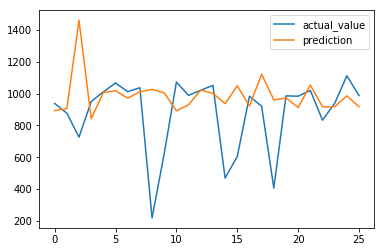

In [99]:
LSTM_prediction.shape
actual_pred_plot(LSTM_prediction)

### 5-2. 정확도 수치 비교

In [100]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

rmse = sqrt(mean_squared_error(y_test, LSTM_prediction))
r2 = r2_score(y_test, LSTM_prediction)

print(rmse)
print(r2)

370.77601265525607
-0.7521017768187345


In [101]:
score = my_LSTM_model.evaluate(X_test, y_test)
print(score)


26/26 [==============================] - 0s 3ms/step
224.3509063720703
